# Machine Learning and Content Analytics

> Konstantinos Ninas, f2822108 <br />
> Stamatios Sideris, f2822113 <br />
> Yiannis Vaniotis, f2822101 <br />
> Orestis Loukopoulos, f2822104 <br />

> MSc in Business Analytics <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />

The scope of this module is to produce summaries of news articles by utilizing a pretrained text summarization model. These summaries will be used to create clusters and to produce a news recommendation engine.

In [7]:
#Ιmport the necessary libraries
import pandas as pd
import numpy as np
import sklearn
from simpletransformers.seq2seq import Seq2SeqModel,Seq2SeqArgs
import torch
import torch.nn as nn
from fastai.text.all import *
from transformers import AutoConfig 
from transformers import BartForConditionalGeneration, BartTokenizer, BartModel
from transformers import BartTokenizer, AutoTokenizer, EncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import textwrap
from sklearn.pipeline import Pipeline
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
import evaluate
from rouge import Rouge
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from collections import Counter

In [ ]:
#read the csv file
mydata = pd.read_csv('initial_dataset.csv', engine = 'python', error_bad_lines = False)

#drop the column 'Unnamed: 0'
mydata = mydata.drop('Unnamed: 0', axis = 1)

mydata

In [ ]:
#drop the duplicate and na values from the records
mydata.drop_duplicates(subset=['Publication_Number'],inplace=True)
mydata.dropna(axis=0,inplace=True)

In [ ]:
len(mydata)

## Descriptives
We plot the distribution of the length of characters for the observations in each column. We also print the 1st, the 2nd and 3rd quantiles of the length of tokens in each column.

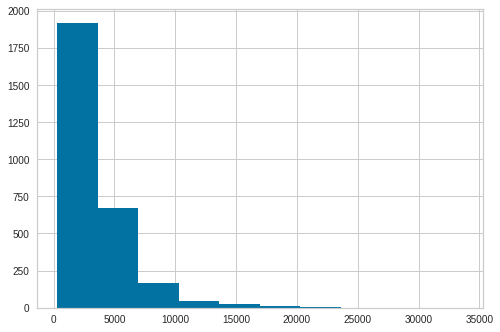

In [ ]:
#Plot for the description column
mydata['Description'].str.split(' ').str.len().hist()

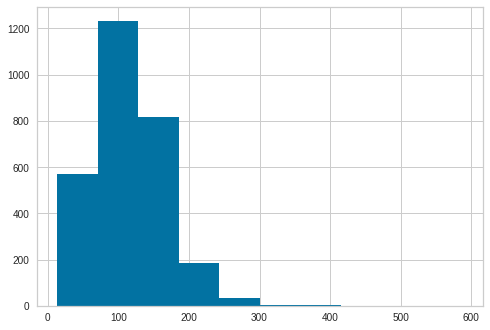

In [ ]:
#Plot for the summary column
mydata['Summary'].str.split(' ').str.len().hist()

In [ ]:
#We print the 1st, 2nd and 3rd quantiles for the Description column
print('The 1st quantile of the descriptions is: ',np.quantile(mydata['Description'].str.replace(',','').str.split().str.len(), 0.25))
print('The 2nd quantile of the descriptions is: ',np.quantile(mydata['Description'].str.replace(',','').str.split().str.len(), 0.5))
print('The 3rd quantile of the descriptions is: ',np.quantile(mydata['Description'].str.replace(',','').str.split().str.len(), 0.75))

The 1st quantile of the descriptions is:  1796.0
The 2nd quantile of the descriptions is:  2606.0
The 3rd quantile of the descriptions is:  4080.5


In [ ]:
#We print the 1st, 2nd and 3rd quantiles for the Summary column
print('The 1st quantile of the summaries is: ',np.quantile(mydata['Summary'].str.replace(',','').str.split().str.len(), 0.25))
print('The 2nd quantile of the summaries is: ',np.quantile(mydata['Summary'].str.replace(',','').str.split().str.len(), 0.5))
print('The 3rd quantile of the summaries is: ',np.quantile(mydata['Summary'].str.replace(',','').str.split().str.len(), 0.75))

The 1st quantile of the summaries is:  75.0
The 2nd quantile of the summaries is:  105.0
The 3rd quantile of the summaries is:  141.5


In [ ]:
#Shuffle data
shuffled_data = mydata.sample(frac=1, random_state = 42)

#We set the train size to 80% of the initial dataset
train_size=0.8

#We assign the description and the summary columns to different variables
X = shuffled_data['Description']
y = shuffled_data['Summary']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [ ]:
#We create an empty dataframe with the columns input_text and target_text
train_df = pd.DataFrame(columns = ['input_text', 'target_text'])

#We assign the x_train and the y_train variables to their corresponding columns in the empty dataframe
train_df['input_text'] = X_train
train_df['target_text'] = y_train

train_df

input_text  \
1     fig1 is a cross - sectional diagram of a manual / auto - prime air elimination system 100 according to one embodiment of the invention . the manual / auto - prime air elimination system 100 includes a drip chamber 102 , an inlet 105 , an outlet 106 , an automatic air eliminator 120 , and a mechanical air eliminator 150 . the drip chamber 102 may contain fluid 110 and air 112 . the manual / auto - prime air elimination system 100 vents air 112 from the drip chamber 102 , as it is imperative that the air 112 not travel into the outlet 106 . the automatic air eliminator 120 includes a body 12...   
2602  described herein are techniques for a dco . in the following description , for purposes of explanation , numerous examples and specific details are set forth in order to provide a thorough understanding of embodiments of the present invention . particular embodiments as defined by the claims may include some or all of the features in these examples alone or in combination with other features described below , and may further include modifications and equivalents of the features and concepts described herein . fig5 shows an example of a dco model 500 according to one embodiment . an lc tank...   
2713  the present invention will now be described with reference to the figures . like reference numbers refer to like or similar regions depicted in the figures . it is to be understood that the several views and the present descriptions are by way of example and that the scope of the current invention is not limited by such views or descriptions . it is understood that both n - and p - type mosfets can be made simultaneously on the same sapphire substrate , as shown throughout fig2 and 3 , thereby comprising complimentary mos ( or cmos ) circuits . in one embodiment , the present invention is ...   
264   in the fixed motor vehicle roof 1 , there is a large roof opening 12 which can be closed or at least partially cleared by means of two successive covers 2 , 3 . the front cover 2 is pivotally coupled by a pivot axis 5 to the front slide elements 6 so that it can be raised at its rear edge above the fixed motor vehicle roof 1 into a ventilator position . the raising motion is produced by the rear slide elements 8 which are part of a mechanism which has raising and support levers which are not shown in detail , but are as known from the initially mentioned published german patent application...   
2451  in fig1 of the drawings a conventional mechanical arrangement is shown for measurement of an unbalance mass in a rotating body . the unbalance mass produces an unbalance force when the body is spun . as depicted therein an automobile rim and tire combination 21 is shown as the rotating body securely mounted against a shoulder member 22 which is attached to the end of a rotating shaft 23 . the rim portion of the rim and tire combination has the usual centrally disposed hole which fits over the end of the shaft 23 . the rim is held tightly in place by a wheel clamp 24 which engages threads f...   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ...   
2419  fig1 to 3 illustrate an example of an external - ignition four - cylinder in - line internal combustion engine having a crankcase 30 with a cylinder head 31 and cylinder head cover 33 of conventional design . two intake and two outlet valves ( not shown ) are installed per cylinder , the intake valves being operated by an in

In [ ]:
#We create an empty dataframe with the columns input_text and target_text
test_df = pd.DataFrame(columns = ['input_text', 'target_text'])

#We assign the x_test and the y_test variables to their corresponding columns in the empty dataframe
test_df['input_text'] = X_test
test_df['target_text'] = y_test

test_df

input_text  \
2198  pharmacologically - acceptable salts of the compounds having the said formula ( i ) are acid addition salts . acid addition salts include mineral acid salts such as hydrochloride , sulfate , nitrate , hydrobromide , hydroiodide , phosphate , etc . ; or organic acid salts such as acetate , maleate , fumarate , citrate or tartarate , etc . according to the present invention the novel compounds , thiophene ring - substituted α -( alkylaminopropionyl )- thiophenes , represented by the general formula ( i ), can be prepared by the following method : ## str3 ## bromine displacement in the compou...   
2530  fig1 shows an equivalent electric circuit of one picture element of a first embodiment of the solid - state optical device according to the invention . the element comprises a mos transistor 1 with the gate 2 thereof connected to an address line 3 . its source 4 is connected to a data line 5 , and its drain 6 is connected to a node p between a liquid crystal cell ( display cell ) 7 which consists of a liquid crystal material and a capacitor 8 into which signal charge on the data line 5 is injected . a plurality of picture elements as described above may be arrayed as a matrix as shown in f...   
2501  fig8 ( a ) is a schematic diagram of a description of the principle of this invention , showing the optical path of a bundle of rays from a reflection surface 7 to the light receiving surface of a light receiving element 9 . optical elements and electric elements which have been described hereinbefore are respectively designated by the same reference numerals . as is apparent from fig8 ( a ), it is assumed that the radius of lens aperture of a convergence lens 5 is &# 34 ; r &# 34 ;. the distance between principle points of the convergence lens 5 and a cylindrical lens 8 is &# 34 ; l &# 34...   
1928  referring not to fig1 and 2 , the dustless drywall finisher of the present invention is shown generally at 10 and contains a handle portion 13 and a sponge portion 15 . the handle portion 13 contains : cap 12 which may be rubber , but is not limited to it , hollow tube 14 containing a rigid aluminum tube 52 , but is not limited to it , plug 16 which may be plastic , but is not limited to it , valve 18 , &# 34 ; l &# 34 ;- fitting 22 , perforated pipe 24 , longitudinal axis 25 , platform head 26 , interior 27 of the sponge 28 , rectangular solid 49 , pressure cap 30 , upper face 31 of the s...   
909   before the description of the present invention proceeds , it is to be noted that like parts are designated by like reference numerals throughout the accompanying drawings . referring now to the drawings , there is shown in fig1 an optical information recording medium according to one preferred embodiment of the present invention , which generally includes a substrate 1 , a first transparent layer 2 of a transparent dielectric material or the like provided on the substrate 1 , a recording thin film layer 3 formed on said first transparent layer 2 , a second transparent layer 4 also of a di...   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ...   
1100  the cosmetic compact 1 shown in fig1 comprises a lid 2 and a base 3 connected by a hinge 4 such as a hinge pin . the lid further comprises a latch 5 which serves to hold the lid 2 closed against the base 3 . fig2 shows a front view of the cosmetic compact 1 . the latch 5 is a flap connected to the lid 2 by a hinge 6 . when t

In [ ]:
#We create an empty dataframe with the columns input_text and target_text
val_df = pd.DataFrame(columns = ['input_text', 'target_text'])

#We assign the x_valid and the y_valid variables to their corresponding columns in the empty dataframe
val_df['input_text'] = X_valid
val_df['target_text'] = y_valid

val_df

input_text  \
2369  a cutting bit 21 according to an embodiment of the present invention is shown in fig1 and 2 . the cutting bit 21 includes a body 23 having a front surface 25 and a side surface 27 . the side surface 27 includes a shoulder 29 below the front surface 25 and extending substantially perpendicular to a central axis of the body . a cutting tip 31 is preferably attached to the front surface 25 , usually by brazing , the cutting tip preferably being harder than the body 23 . a ring 33 that is preferably harder than the body 23 is attached to the body at a front surface 35 of the shoulder 29 , such...   
2286  two alternate processes will be described . both are the same as to the broad process steps given in fig1 but slightly different as to detail . the first process uses the apparatus of fig2 and 5 in combination , whereas the second substitutes the apparatus of fig3 for that of fig2 . it will facilitate the overall understanding , first to explain the apparatus , and then to explain the functions and process . fig2 depicts a small vial designated 1 , with a cover 2 , and a cover retainer 3 , and containing a lysing - staining solution 4 . the vial may conveniently be of standard commerical c...   
2329  r 1 is hydrogen , ( c 1 - 6 ) alkylthio , halo ( c 1 - 6 ) alkylthio ( c 1 - 6 ) alkylsulphinyl , halo ( c 1 - 6 ) alkylsulphinyl , ( c 1 - 6 ) alkylsulphonyl , halo ( c 1 - 6 ) alkylsulphonyl or nr 12 r 13 ; r 12 and r 13 are each independently hydrogen , ( c 1 - 6 ) alkyl , or halo ( c 1 - 6 ) alkyl ; r 2 , r 3 , r 4 , r 5 , r 6 , r 7 , r 8 , r 9 and r 11 are each independently selected from hydrogen , halogen , cyano , nitro , ( c 1 - 6 ) alkyl , halo ( c 1 - 6 ) alkyl , ( c 1 - 6 ) alkoxy , halo ( c 1 - 6 ) alkoxy , ( c 1 - 6 ) alkoxy ( c 1 - 6 ) alkyl , halo ( c 1 - 6 ) alkoxy ( c 1 -...   
158   with reference to the drawings , and in particular to fig1 - 4 , the lawn mower of the present invention is indicated generally at 10 . the lawn mower of the invention generally comprises a housing / frame 12 , a blade member 16 which is coupled via a clutch and roller bearing 242 to a vertical axle 118 , a horizontal axle 18 , drive wheels 30 , 32 which are coupled to the horizontal axle 18 via clutch and roller bearings 34 , 36 , and a gear mechanism 25 which couples the horizontal axle 18 to the vertical axle 118 . the housing 12 of the lawn mower 10 is open at its bottom 14 . the blade...   
2335  fig1 is a set of a graphs illustrating the expression of hla - class i ( w6 / 32 ), cd29 ( 4b4 ), cd54 ( icam - 1 ) and cd58 ( lfa - 3 ) on freshly isolated 99 - 97 % pure whole human islets of langerhans by indirect immunoflourescence and flow cytometry . a . human islets were positive at 36 % with w6 / 32 antibody (- - - ). b . human islets were negative for cd29 with 9 % expression (- - - ). c . human islets in this clean islet preparation were virtually negative for icam - 1 with 14 % expression (- - - ). b . human islets were negative for lfa - 3 expression with 10 . 2 % of the cells ...   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ...   
1749  a preferred embodiment of a crimp terminal of the present invention will now be described in detail with reference to the drawings . fig1 is a perspective view showing one preferred embodiment of a wire fixing structure of the invention in the crimp terminal , fig2 is a developed view showing sheath fixing portions and a cri

In this section we will load the pretrained facebook/bart-large tokenizer and text summarization model to further train it with a portion of our data and produce new summaries. We will evaluate the produced summaries using the Rouge metrics.

In [ ]:
#We load the pretrained facebook/bart-large tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

In [ ]:
#We set the model arguments that we will later input inside the model object
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "train_batch_size": 5,
    "num_train_epochs": 10,
    "save_eval_checkpoints": True,
    "save_model_every_epoch": True,
    "evaluate_generated_text": True,
    "evaluate_during_training_verbose": True,
    "use_multiprocessing": False,
    "max_length": 1024,
    "manual_seed": 4,
    "metrics":['accuracy']
}


In [ ]:
# Initialize a Seq2SeqModel. We input the arguments and the data collator that were set above
# We also load the pretrained facebook/bart-large model.
model = Seq2SeqModel(
    encoder_decoder_type="bart",
    encoder_decoder_name="facebook/bart-large",
    args=model_args,
    pretrained=True
)


In [ ]:
#We used the 1st and 3rd quantiles of the length of the existing summaries that were calculated before to set the 
#lower and upper bounds of the summaries that will be produced by the model
model.config.max_length = 150
model.config.min_length = 70

#We set further configurations for the model's training
model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
model.model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

In [ ]:
#Model training
model.train_model(train_df, eval_data = val_df )

  0%|          | 0/1386 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/278 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/278 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/278 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/278 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/278 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/278 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/278 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/278 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/278 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/278 [00:00<?, ?it/s]

In [ ]:
running_loss = [3.2874, 2.3103, 2.0430, 1.8243, 2.0870, 1.7629, 1.6127, 1.2558, 1.2933, 1.3709]
epochs_var = range(1,11)

Text(0, 0.5, 'Running Loss')

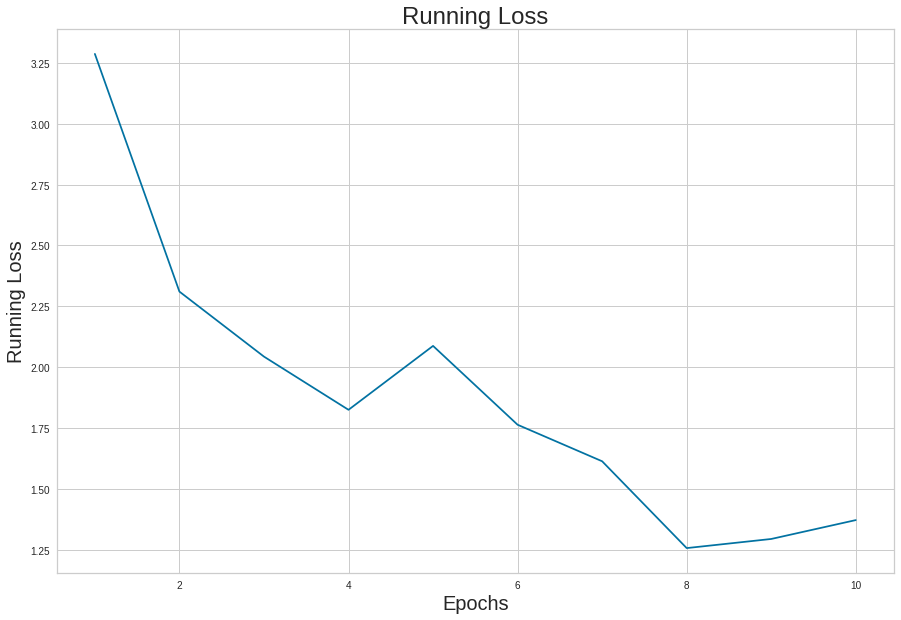

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(epochs_var, running_loss, )
plt.title("Running Loss", fontsize = 24)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel("Running Loss", fontsize = 20)


In [ ]:
#Load model's weights
torch.load('/content/outputs/pytorch_model.bin')

{'final_logits_bias': tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'model.shared.weight': tensor([[-0.0370,  0.1117,  0.1829,  ...,  0.2054,  0.0578, -0.0750],
         [ 0.0055, -0.0049, -0.0069,  ..., -0.0030,  0.0038,  0.0087],
         [-0.0448,  0.4604, -0.0604,  ...,  0.1073,  0.0310,  0.0477],
         ...,
         [-0.0138,  0.0278, -0.0467,  ...,  0.0455, -0.0265,  0.0125],
         [-0.0043,  0.0153, -0.0567,  ...,  0.0496,  0.0108, -0.0099],
         [ 0.0053,  0.0324, -0.0179,  ..., -0.0085,  0.0223, -0.0020]],
        device='cuda:0'),
 'model.encoder.embed_tokens.weight': tensor([[-0.0370,  0.1117,  0.1829,  ...,  0.2054,  0.0578, -0.0750],
         [ 0.0055, -0.0049, -0.0069,  ..., -0.0030,  0.0038,  0.0087],
         [-0.0448,  0.4604, -0.0604,  ...,  0.1073,  0.0310,  0.0477],
         ...,
         [-0.0138,  0.0278, -0.0467,  ...,  0.0455, -0.0265,  0.0125],
         [-0.0043,  0.0153, -0.0567,  ...,  0.0496,  0.0108, -0.0099],
         [ 0.0053,  0.0

In [ ]:
#We set Rouge as the metric for the model evaluation 
metric = evaluate.load("rouge")

In [ ]:
#We initialize the Rouge metric
ROUGE = Rouge()

#We get the rouge scores of a single summary prediction
ROUGE.get_scores(model.predict([test_df.loc[734,'input_text']]), [test_df.loc[734,'target_text']])

In [ ]:
#We print the predicted summary of an existing description
model.predict([test_df.loc[734,'input_text']])

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['an electromagnetic relay for use in a motor - driven vehicle comprises a box - shaped casing, a pair of contact units, an armature, a hinge spring and a cover. the box - shape casing is adapted to be operative in a rotating type of vehicle. the contact units are adapted to operate electromagnetically, and are adapted for operation in a closed position. the hinge spring is adapted for operating in a open condition. the cover is adapted in a folded position for covering the opening in the casing. the electromagnetic relay is capable of providing high frequency signal strength, high signal resolution and high ac']

In [ ]:
#We evaluate the model using the test data (it has not previously seen them)
model.eval_model(test_df, verbose=1, output_dir = '/content')

  0%|          | 0/286 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 2.941362851195865}

In [ ]:
#We predict all the summaries of test dataframe (unseen data for the model)
predicted_summaries = []
for j in test_df.index:
  predicted_summaries.append(model.predict([test_df.loc[j,'input_text']])[0])

{'rouge-1': {'r': 0.2930014806112098,
  'p': 0.32619461918103954,
  'f': 0.2986435748393967},
 'rouge-2': {'r': 0.09253436669621828,
  'p': 0.09401896774938544,
  'f': 0.08934765873643395},
 'rouge-l': {'r': 0.2560062958001257,
  'p': 0.28455482406047045,
  'f': 0.26076445112477453}}

In [ ]:
#We create a list that will iteratively store the validated summaries for each article
true_summ = []
for k in test_df.index:
  true_summ.append(test_df.loc[k,'target_text'])

In [ ]:
#We calculate the rouge scores for the predicted summaries
ROUGE.get_scores(predicted_summaries, true_summ, avg = True)

{'rouge-1': {'r': 0.2930014806112098,
  'p': 0.32619461918103954,
  'f': 0.2986435748393967},
 'rouge-2': {'r': 0.09253436669621828,
  'p': 0.09401896774938544,
  'f': 0.08934765873643395},
 'rouge-l': {'r': 0.2560062958001257,
  'p': 0.28455482406047045,
  'f': 0.26076445112477453}}

In [ ]:
model.predict([test_df.loc[j,'input_text']])[0]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['a lower limb prosthesis includes a foot, a foot / pylon joint, a pylon / stump joint and a pylophone. the foot has a sole and a metatarsal. the pylon has a socket and a plurality of projections extending therethrough. the socket has a hollow structure and a hollow body. the hollow body is hollow and has a number of projections therethrough, each of which is connected to a socket. the projections are connected to the pyloid joint and the stump joint. the shaft of the pyle is connected in series with the shaft and is hollow. the proximal and distal']

In [ ]:
#We create a new column in the initial dataframe
mydata['Predicted_Summaries'] = 'None'

In [ ]:
#We create a for loop that will iteratively predict the summaries of all articles in the initial dataframe
for i in range(len(mydata)):
  mydata.loc[i, 'Predicted_Summaries'] = model.predict([mydata.loc[i,'Description']])

NameError: ignored

In [ ]:
#We create an empty dictionary and will fill it with the f1-scores of the rouge-1 between the predicted and the actual summaries
rouges={}
for k in range(len(mydata)):
  rouges[k] = ROUGE.get_scores(mydata.loc[k, 'Summary'], mydata.loc[k, 'Predicted_Summaries'])[0]['rouge-1']['f']

#we sort the dictionary based on the f1-scores in ascending order
sorted_list = sorted(rouges.items(), key=lambda kv: kv[1], reverse=False)
sorted_list

[(1022, 0.056338024122198266),
 (1461, 0.07476635014411773),
 (435, 0.07692307210798846),
 (1573, 0.09677418956815832),
 (1666, 0.09836065171728046),
 (2203, 0.1052631529701449),
 (1328, 0.11538461040125761),
 (1396, 0.11570247552762804),
 (1900, 0.11594202411258159),
 (20, 0.11881187619253036),
 (1057, 0.12048192276963296),
 (291, 0.12048192292059824),
 (2323, 0.12195121461927444),
 (434, 0.12307691881656818),
 (572, 0.12371133544053584),
 (499, 0.1249999950500002),
 (326, 0.12727272300165302),
 (411, 0.12820512394477332),
 (38, 0.12844036219510158),
 (2033, 0.1315789427146816),
 (2243, 0.13207546670523337),
 (21, 0.13432835449654723),
 (544, 0.13461537964497058),
 (2238, 0.13483145572528737),
 (2311, 0.1359223251541146),
 (308, 0.13698629715894178),
 (1254, 0.13888888464506186),
 (986, 0.13999999551200015),
 (1409, 0.1411764656221455),
 (1510, 0.14285713820011353),
 (1495, 0.1438848881134518),
 (2242, 0.14399999500288016),
 (1739, 0.14432989288978648),
 (1586, 0.14492753251837862),
 

In [ ]:
#We print the 5 words predicted summaries based on the f1-score of the rouge-1 measure to examine them
mydata.loc[(1022, 1461, 435, 1573, 1666),('Description','Summary', 'Predicted_Summaries')]

Description  \
1022  the present invention regards in particular an implanting device in the human or animal body , in which at least one part of the surface of said device is coated with a hyaluronic acid compound with a glycopeptide antibiotic . the idea is to bond a layer of hyaluronic acid to the surfaces of interest ( through the methods known in the art ), then incubate such surfaces with a solution of vancomycin in presence of condensing agents , in particular n - hydroxysuccinimide ( nhs ) and 1 - ethyl - 3 -( 3 - dimethylaminopropyl ) carbodiimide ( edc ), present simultaneously : an “ opaque ” layer ...   
1461  in the following paragraphs , the present invention will be described in detail by way of example with reference to the attached drawings . throughout this description , the preferred embodiment and examples shown should be considered as exemplars , rather than as limitations on the present invention . as used herein , the “ present invention ” refers to any one of the embodiments of the invention described herein , and any equivalents . furthermore , reference to various feature ( s ) of the “ present invention ” throughout this document does not mean that all claimed embodiments or metho...   
435   the compounds of formula i contain a --( cr 5 r 6 ) n -- substituent wherein each r 5 group and each r 6 group may vary independently . thus , for example , when n equals 2 , the following patterns of substitution ( wherein hydrogen and ch 3 are used to represent any substituent , r 5 or r 6 ) are contemplated : -- ch 2 ch 2 --, -- ch ( ch 3 ) ch 2 --, -- ch 2 ch ( ch 3 )--, -- c ( ch 3 ) 2 ch 2 --, -- ch 2 c ( ch 3 ) 2 --, --( c ( ch 3 ) h ) 2 --, and the like . in the same manner , each r 3 in the group --( chr 3 ) m -- may vary . as noted above , the compounds of the invention may inclu...   
1573  disclosed herein is a system that can be used to analyze images of objects that contain an apparently random pattern or network that contains a flow field . this system imports an image ( e . g ., a medical image , a topographical image of a stream or a river , electrical circuitry where electrical percolation is desirable , or the like ) and uses spatial analysis methods ( e . g ., voronoi diagrams , delaunay triangulations , network topology , and the like ) to determine the organization of biological or other topographical structures contained in the image and combines the spatial analy...   
1666  the disclosure provided in the following pages describes examples of some embodiments of the invention . the designs , figures , and descriptions are non - limiting examples of certain embodiments of the invention . for example , other embodiments of the disclosed device may or may not include the features described herein . moreover , disclosed advantages and benefits may apply to only certain embodiments of the invention and should not be used to limit the disclosed inventions . where parts are connected , descriptions herein include the term “ coupled ” which refers to either direct or ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Summary  \
1022                                                                                                                                                                                                                                                                                                                                      

In [ ]:
#We print 50 random articles to examine the predicted and the actual summaries vs the initial description of the article
mydata.loc[random.sample(range(len(mydata)), 50),('Description','Summary', 'Predicted_Summaries')]

Description  \
397   references will now be made to the drawings to describe the exemplary embodiments of the present cnt needle and the method for manufacturing the cnt needle , in detail . referring to fig1 , the cnt needle 10 is composed of a cnt string . each cnt string includes a plurality of continuously oriented and substantially parallel cnts joined end - to - end by van der waals attractive force . a diameter of the cnt needle 10 approximately ranges from 1 to 20 microns , and a length thereof ranges from 0 . 01 to 1 millimeters . the cnt needle 12 includes an end portion 122 and a broken end portion ...   
1711  embodiments of the invention provide for client side cache management . in an embodiment of the invention , different browser sessions can register to utilize web storage for a particular domain . as one of the different browser sessions accesses the web storage , the others of the browser sessions can receive notification of the attempt by the one of the browser session and each of the others of the browser session can determine whether or not to remove or compress entries from the web storage and can individually act upon this determination . in this way , cache invalidation can be perfo...   
702   before any embodiments of the invention are explained in detail , it is to be understood that the invention is not limited in its application to the details of construction and the arrangement of components set forth in the following description or illustrated in the following drawings . the invention is capable of other embodiments and of being practiced or of being carried out in various ways . also , it is to be understood that the phraseology and terminology used herein is for the purpose of description and should not be regarded as limiting . the use of “ including ,” “ comprising ,” ...   
140   referring to fig1 of the drawings , a leg plate 11 in accordance with this embodiment of the invention is fastened to a leg 12 of an expectant mother prior to delivery of the fetus to sense the electrical potential or voltage of the maternal skin . the leg plate 11 also functions as a circuit junction for interconnecting other components of a fetal heart rate monitoring system 13 . the other components of the system 13 are a fetal heart rate sensing device 14 and a heart rate monitor 16 which includes a signal processing circuit 17 that controls a data display 18 . the device 11 is herein ...   
1946  as used herein and in the claims , “ comprising ” means including the following elements but not excluding others . in this study , novel autophagy enhancers with neuroprotective effects by evaluating their efficacy in enhancing the clearance of mutant huntingtin and α - synuclein , and in increasing of cells viability , are identified . through screening of their library of natural product extracts from the chinese medicinal herbs , inventors have demonstrated that both ethanol extract of radix polygalae and its single component , onjisaponin b , are able to induce autophagy with potentia...   
984   the device shown in the drawings comprises a body 1 of any suitable shape , preferably designed for having ergonomic qualities , particularly in order to be easily maintained in hand of a user when the user wishes to present a distribution head 2 , which is described hereafter , on a portion of his body to be treated . the body 1 of the device is hollow and contains a piezoelectric generator 3 which can be operated by a boss 4 of a handle or pedal 5 through pressure exerted by the user on the handle or pedal 5 . fig1 shows that the handle 5 is articulated for example on a pin 6 . it is adv...   
1013  in the following detailed description , certain specific terminology will be utilized and a particular embodiment described for the sake of clarity in accordance with the requirements of 35 usc 112 , but it is to be understood that the practice of the invention is capable of assuming many forms within the scope of the inven

In this section we will create clusters using the embeddings of the produced summaries. We will also use the both the clusters and the embeddings to create a recommendation engine.

In [9]:
#We create a list that will contain a summary in each list's item
#We will input all the summaries produced from the predictions of the pretrained model
sequences = [x for x in mydata.loc[:,'Predicted_Summaries']]
sequences

['a novel opioid receptor antagonist is disclosed for treating eye disorders. the novel opioid receptors are useful for treating, and preventing, pupil stinging, pupil injury and pupil dilation. the disclosed methods include the steps of administering naltrexone eye drops in a dosage form of sufficient concentration to effectively control pupil size and to effectively prevent pupil injury. the effective amount of naltroxone eye drop in a dose of sufficient quantity and time is determined by the clinician. the effectiveness of nalrexone in combination with other pharmaceuticals is also shown.',
 'a manual / auto - prime air elimination system includes a drip chamber having an inlet and an outlet, an automatic air eliminator, a mechanical air eliminer, and a manual air vent. the automatic air vent is operable to vent air from the drip chamber into an inlets of the automatic and auto - pacsatures. the mechanical air vent includes a first air passage having a first opening and an air outle

In [10]:
#We initialize a sentence transformer that will produce embeddings
emb_model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [11]:
#We create embeddings for all summaries
summary_embeddings = emb_model.encode(sequences)
summary_embeddings

array([[-0.46286312,  0.63047016,  0.60908467, ..., -0.5353812 ,
        -0.97728205,  0.4722273 ],
       [ 0.14354771,  0.27657932,  0.47456855, ...,  0.41060114,
        -0.3422457 ,  0.36212963],
       [-0.3817339 ,  0.2003943 ,  0.3065543 , ..., -0.36716232,
        -0.27154744,  1.0277178 ],
       ...,
       [ 0.11085166,  0.47630602,  0.78868353, ...,  0.10437322,
        -0.46955606, -0.13836259],
       [-0.35029882,  0.22309479, -0.22896881, ..., -0.73242134,
        -0.69493896,  0.29232082],
       [ 0.19879445,  0.5112831 ,  0.46145165, ...,  0.32108724,
        -0.8267459 ,  0.5896511 ]], dtype=float32)

In [12]:
#We input an example query that will be encoded to embeddings
query = 'a keratotomy incision is formed in a cornea manipulating an rk knife so that its blade extends a preselected depth into a preselected point on the cornea .'
query_vec = emb_model.encode([query])[0]
query_vec

array([ 1.19114399e-01,  5.15250087e-01,  7.58570880e-02,  8.12699459e-03,
        3.17498982e-01,  7.21439064e-01, -1.80365577e-01,  1.03267461e-01,
        2.16079131e-01, -6.66332960e-01,  5.15645921e-01,  4.48383600e-01,
        9.79255140e-01,  8.30112040e-01, -1.71609163e-01,  2.23473459e-01,
       -5.44867694e-01, -3.80145133e-01, -1.63536012e-01, -2.49423534e-01,
       -6.08440161e-01, -6.52325988e-01,  1.07919860e+00,  6.90310299e-01,
        3.65708679e-01,  1.38294065e+00, -1.05042636e-01,  4.39040601e-01,
        1.61897507e-03, -4.31329280e-01, -9.52591822e-02, -1.01743722e+00,
        1.17413312e-01, -1.30052876e+00, -1.36397183e-01, -1.56602994e-01,
        5.93606271e-02,  7.24779427e-01,  5.29880106e-01,  3.94992471e-01,
       -6.63924038e-01,  1.45837635e-01,  2.76262492e-01, -6.77540824e-02,
       -5.89662552e-01, -5.80641568e-01,  4.94142830e-01,  8.81266594e-01,
       -1.70330942e-01,  4.01205361e-01,  7.50600025e-02, -3.52130234e-01,
        3.68008584e-01, -

In [13]:
#We define a function that will calculate cosine similarity between two embedding vectors
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [14]:
#We create a counter starting from 0 and an empty dictionary
counter = 0
sim_dict = {}
#We iterate through all the summaries
for sent in sequences:
  #We calculate the cosine similarity between the embedding of the query and all the existing embeddings
  sim = cosine(query_vec, emb_model.encode([sent])[0])
  #We add the index and the similarity in the dictionary as key-value pairs
  sim_dict[counter] = sim
  counter += 1

In [15]:
#We sort the key-value pairs in the dictionary by their cosine similarity in descending order and print the 3 most similar summaries
sorted_sim_list = sorted(sim_dict.items(), key=lambda kv: kv[1], reverse=True)
print('The 3 most similar documents are:')
for i in range(0,3):
  print(sorted_sim_list[i][0], 'with a similarity of', round(sorted_sim_list[i][1],2))

The 3 most similar documents are:
8 with a similarity of 0.78
2806 with a similarity of 0.76
554 with a similarity of 0.75


In [16]:
#We create an empty dataframe with the number of columns equal to the number of columns of the embeddings
embeddings_df = pd.DataFrame(columns=np.arange(768))
embeddings_df

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 768 columns]

In [17]:
#We input all the embeddings in the empty dataframe
for i in range(len(mydata)):
    embeddings_df.loc[len(embeddings_df)] = summary_embeddings[i]

embeddings_df

0         1         2         3         4         5         6    \
0    -0.462863  0.630470  0.609085  0.074658  0.327698 -0.241923  0.917243   
1     0.143548  0.276579  0.474569  0.458749  0.193791 -0.519110  0.269521   
2    -0.381734  0.200394  0.306554 -0.286915  1.436473 -0.078265 -0.051344   
3    -0.253646 -0.218423  1.458506  0.338235  0.099088 -0.150836 -0.233484   
4    -0.312380  0.568287  0.816453  0.156036  0.655141 -0.262974  0.734006   
...        ...       ...       ...       ...       ...       ...       ...   
2846 -0.498220  0.501859  0.549003  0.797093 -0.159579 -1.083264 -0.163808   
2847 -0.120995  0.666643  0.811853  0.743101  0.041793 -0.739863  0.409301   
2848  0.110852  0.476306  0.788684  0.252844  0.371228 -0.069154  0.367458   
2849 -0.350299  0.223095 -0.228969  0.452605  0.111741 -1.056200 -0.073012   
2850  0.198794  0.511283  0.461452  0.762127  0.691092 -1.015836  0.253349   

           7         8         9    ...       758       759       760  \
0    -0.813969  0.719090 -0.478414  ... -0.431614 -0.807156 -1.208235   
1    -0.551217  0.573058 -0.571999  ...  0.197301 -0.566465 -0.905465   
2    -0.370764  0.799157 -0.660576  ... -0.142747  0.093346  0.065183   
3    -1.200559  0.304954 -0.523857  ...  0.114907 -0.486693 -0.542778   
4    -0.376581  0.813128  0.286052  ...  0.236990 -0.359860 -1.179537   
...        ...       ...       ...  ...       ...       ...       ...   
2846 -0.589750  0.373337 -0.631749  ...  0.169371 -0.740613  0.079910   
2847 -0.401755  0.242501 -0.527496  ... -0.456460 -0.098016 -0.380897   
2848 -0.682108 -0.190876 -0.375831  ...  0.366520 -0.121438 -1.165753   
2849 -0.654184  0.882417 -0.746584  ...  0.365875 -0.774311 -0.440611   
2850 -0.360326  0.234718 -0.089652  ...  0.101767 -0.359282 -0.045702   

           761       762       763       764       765       766       767  
0    -1.324294  0.167001 -0.188054  0.044602 -0.535381 -0.977282  0.472227  
1    -0.072641 -0.603813 -0.628955  0.066560  0.410601 -0.342246  0.362130  
2     0.044221  0.294584 -0.370495 -0.475183 -0.367162 -0.271547  1.027718  
3    -0.655133  0.138530 -0.226919 -0.846251  0.082267 -0.171234  0.268447  
4    -0.563912  0.243507  0.458895 -0.014447 -0.740456 -0.293054  0.794869  
...        ...       ...       ...       ...       ...       ...       ...  
2846 -0.555144 -0.151735 -0.628544 -0.501681 -0.331824 -0.867875  0.492969  
2847 -1.788071 -0.777180 -0.248971  0.295994 -0.310294 -0.873020  0.763248  
2848 -0.501201 -0.370524 -0.845704 -0.298226  0.104373 -0.469556 -0.138363  
2849 -0.858922 -1.151909 -0.216561  0.022682 -0.732421 -0.694939  0.292321  
2850 -0.973846 -0.835757 -0.339909 -0.036615  0.321087 -0.826746  0.589651  

[2851 rows x 768 columns]

In [ ]:
#We create an empty list that will include the clusters' distortions
distortions = []
#We set different numbers of clusters 
K = range(1,16)
#We conduct KMeans clustering for all the different number of clusters that defined in order to identify the
#appropriate number of clusters
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    #We fit the embeddings in the KMeans object
    kmeanModel.fit(embeddings_df)
    #We append the distortion in the list
    distortions.append(kmeanModel.inertia_)

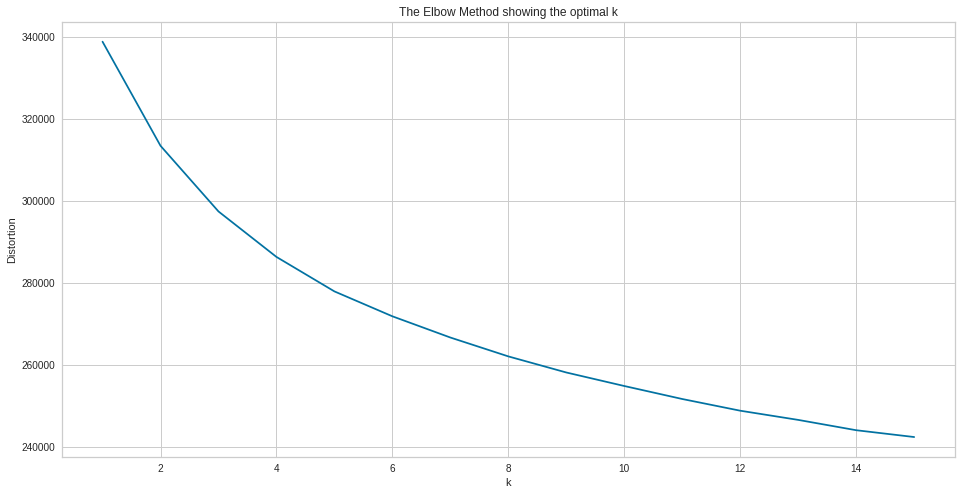

In [ ]:
#We plot the distortion for the different clusters using the elbow method
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [19]:
#We fit the model with 6 clusters
kmeanModel = KMeans(n_clusters=6)
kmeanModel.fit(embeddings_df)

KMeans(n_clusters=6)

In [20]:
#We create an empty column that will store the cluster for each article
mydata['cluster'] = kmeanModel.labels_ 

In [24]:
#We export the dataframe with the predicted summaries to csv format
mydata.to_csv('/content/Summaries.csv')

In [ ]:
#We calculate the avreage silhouette score for the final number of clusters
score = silhouette_score(embeddings_df, kmeanModel.labels_, metric='euclidean')
score

0.061934434

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f30a98b4810>,
                     colors='yellowbrick',
                     estimator=KMeans(max_iter=100, n_clusters=6,
                                      random_state=42))

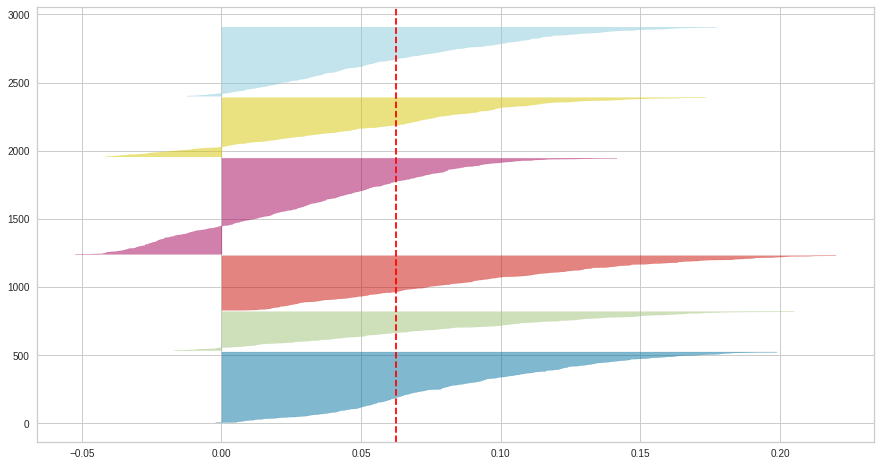

In [ ]:
#We plot the silhouette plot containing the silhouette values
fig, ax = plt.subplots(1, 1, figsize=(15,8))
i = 6 # we will input the number of clusters
'''
Create KMeans instance for different number of clusters
'''
km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
q, mod = divmod(i, 2)
'''
Create SilhouetteVisualizer instance with KMeans instance
Fit the visualizer
'''
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(embeddings_df)

In [ ]:
#We create a function that will identify and recommend the 3 most similar articles to one text sequence given
def recommendation_pipeline(text):

  #we predict the summary of the text given using the trained model
  text_summary = model.predict([text])

  #We create an embedding matrix for the query
  text_emb = emb_model.encode(text_summary)[0]

  #We predict the cluster to which this specific query should be assigned to
  text_cluster = kmeanModel.predict(text_emb.reshape(1, -1))

  #We will calculate the cosine similarity of the embedding of the query to those that belong in the same cluster
  text_sim_dict = {}
  for i in range(len(sequences)-1):
    if kmeanModel.labels_[i] == text_cluster:
      sim = cosine(text_emb, emb_model.encode([sequences[i]])[0])
      text_sim_dict[i] = sim
    else:
      continue

  #We sort the key value pairs based on their cosine similarity
  sorted_sim_list_text = sorted(text_sim_dict.items(), key=lambda kv: kv[1], reverse=True)
  print('The 3 most similar documents are:')
  #We print the top 3 summaries along with their cosine similarity
  for i in range(1,4):
    print(sorted_sim_list_text[i][0], 'with a similarity of', round(sorted_sim_list_text[i][1],2))
    print(textwrap.fill(mydata.loc[sorted_sim_list_text[i][0], 'Summary'], 150), '\n')
  


In [ ]:
#Example of an application of the function
#We give a specific text
query = mydata.loc[107,'Description']

#Implementation of the created pipeline
recommendation_pipeline(query)

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

The 3 most similar documents are:
971 with a similarity of 0.72
a device for delivering a drug implant to an implant site comprises a needle having a lateral opening in which the drug implant is releasably held .
once at the implant site , the drug implant is released directly form the opening . the invention obviates the need for a cannula through which a drug
implant is delivered , and therefore obviates the many problems associated with a cannula - type delivery device . 

1099 with a similarity of 0.71
an instrument and method for performing a surgical fastening procedure at a location remote from the location at which the instrument is manipulated .
the instrument is at least partly self - powered by self - powering apparatus adjacent the location at which the fastening procedure is performed ,
the self - powering apparatus being controlled from the location at which the instrument is manipulated . the relatively large forces required for the
surgical fastening procedure are confi

In [64]:
#We will create a dataframe that will contain for each publication its 3 most similar publications
recommendations=pd.DataFrame(columns=['publication_number','recommendation_1','recommendation_2','recommendation_3'])

In [65]:
for j in mydata.index:
  #we predict the summary of the text given using the trained model
  text_summary = mydata.loc[j, 'Predicted_Summaries']

  #We create an embedding matrix for the query
  text_emb = emb_model.encode(text_summary)

  #We will calculate the cosine similarity of the embedding of the query to those that belong in the same cluster
  text_sim_dict = {}
  for i in range(len(sequences)-1):
    if kmeanModel.labels_[i] == kmeanModel.labels_[j]:
      sim = cosine(text_emb, emb_model.encode([sequences[i]])[0])
      text_sim_dict[i] = sim
    else:
      continue

  #We sort the key value pairs based on their cosine similarity
  sorted_sim_list_text = sorted(text_sim_dict.items(), key=lambda kv: kv[1], reverse=True)

  publ_nums = []
  for i in range(1,4):
    publ_nums.append(mydata.loc[sorted_sim_list_text[i][0], 'Publication_Number'])
  
  recommendations.loc[j,] = [mydata.loc[j, 'Publication_Number'], publ_nums[0], publ_nums[1], publ_nums[2]]

KeyboardInterrupt: ignored

In [67]:
#We export the dataframe with the recommendations to csv format
recommendations.to_csv('/content/Recommendations.csv')